In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv("russian_comments_from_2ch_pikabu.csv")
df = df.drop(columns=["translated"]).rename(columns={"toxic": "label"})
df["comment"] = df["comment"].apply(lambda x: x.strip())
df["label"] = df["label"].astype(int)

# Предварительное обучение эмбеддингов слов

In [4]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

corpus = df["comment"].to_list()

tokenized_sentences = [word_tokenize(sentence.lower()) for sentence in corpus]

model = Word2Vec(
    sentences=tokenized_sentences,
    vector_size=10,  # Dimension of word vectors
    window=5,         # Context window size
    min_count=1,      # Ignore words with frequency less than this
    sg=0              # 0 for CBOW, 1 for Skip-gram
)

# Save the model
model.save("word2vec_model.bin")

# Векторизация текстов

In [5]:
df = df[:10]

In [6]:
max_len = max([len(sentence) for sentence in tokenized_sentences])

df["vectorized_seq"] = df["comment"].apply(lambda x: np.array([model.wv[word] for word in word_tokenize(x.lower())]))


padded_sequences = []
for row in df.iterrows():
    padded_sequences.append(np.pad(row[1]["vectorized_seq"], ((0, max_len - len(row[1]["vectorized_seq"])), (0, 0)), constant_values=0))

In [7]:
df["vectorized_seq"] = padded_sequences

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    df["vectorized_seq"].to_numpy(),
    df["label"].to_numpy(),
    test_size=0.2,
    random_state=42
)

y_train = np.eye(2)[y_train]
y_val = np.eye(2)[y_val]

# Обучение трансформера

In [16]:
y_val.shape

(2, 2)

Training Transformer with CrossEntropy loss...
Model architecture: 2 layers, 2 heads, d_model=64, d_ff=128


100%|██████████| 125/125.0 [00:01<00:00, 73.97it/s]


Epoch 1/10 - loss: 0.8767 - val_loss: 0.8480 - val_accuracy: 0.4875


100%|██████████| 125/125.0 [00:01<00:00, 78.32it/s]


Epoch 2/10 - loss: 0.8205 - val_loss: 0.9076 - val_accuracy: 0.4675


100%|██████████| 125/125.0 [00:01<00:00, 75.89it/s]


Epoch 3/10 - loss: 0.7743 - val_loss: 0.8270 - val_accuracy: 0.5025


100%|██████████| 125/125.0 [00:01<00:00, 75.54it/s]


Epoch 4/10 - loss: 0.7822 - val_loss: 0.8279 - val_accuracy: 0.4575


100%|██████████| 125/125.0 [00:01<00:00, 78.40it/s]


Epoch 5/10 - loss: 0.8053 - val_loss: 0.8234 - val_accuracy: 0.5050


100%|██████████| 125/125.0 [00:01<00:00, 76.36it/s]


Epoch 6/10 - loss: 0.7481 - val_loss: 0.8943 - val_accuracy: 0.4725


100%|██████████| 125/125.0 [00:01<00:00, 78.12it/s]


Epoch 7/10 - loss: 0.7766 - val_loss: 0.8084 - val_accuracy: 0.4775


100%|██████████| 125/125.0 [00:01<00:00, 77.95it/s]


Epoch 8/10 - loss: 0.7602 - val_loss: 0.7965 - val_accuracy: 0.4475


100%|██████████| 125/125.0 [00:01<00:00, 77.64it/s]


Epoch 9/10 - loss: 0.7651 - val_loss: 0.8032 - val_accuracy: 0.4925


100%|██████████| 125/125.0 [00:01<00:00, 78.00it/s]


Epoch 10/10 - loss: 0.7428 - val_loss: 0.7892 - val_accuracy: 0.5075

Training completed!
Final training loss: 0.7428
Final validation loss: 0.7892
Final validation accuracy: 0.5075

Test output shape: (2,)
Predicted class: 0, True class: 1
Transformer training example completed successfully!


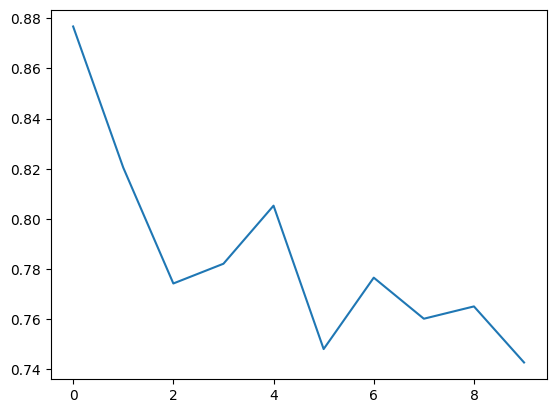

In [31]:
import numpy as np

from nn.transformer_model import Transformer
from nn.losses.cross_entropy import CrossEntropy
from nn.optimizers.adam import Adam
import matplotlib.pyplot as plt

# Model hyperparameters
n_inputs = 10      # Input feature dimension
d_model = 64     # Model dimension
n_heads = 2        # Number of attention heads
n_layers = 2       # Number of transformer blocks
d_ff = 128         # Feed-forward dimension
n_outputs = 2    # Number of output classes
seq_len = 20       # Sequence length
# num_samples = 200 # Number of training samples

# Create transformer model
model = Transformer(
    n_inputs=n_inputs,
    d_model=d_model,
    n_heads=n_heads,
    n_layers=n_layers,
    d_ff=d_ff,
    n_outputs=n_outputs,
    max_seq_len=seq_len
)

# Create sample training data
# Shape: (num_samples, seq_len, n_inputs)
X_train = np.random.randn(2000, seq_len, n_inputs)
# Create one-hot encoded labels for n_outputs classes
y_train = np.eye(n_outputs)[np.random.choice(n_outputs, 2000)].astype(np.float32)

# # Create sample validation data
X_val = np.random.randn(400, seq_len, n_inputs)
y_val = np.eye(n_outputs)[np.random.choice(n_outputs, 400)].astype(np.float32)

# Create CrossEntropy loss function
loss_fn = CrossEntropy()
optimizer = Adam(learning_rate=0.001)

# Train the model
print("Training Transformer with CrossEntropy loss...")
print(f"Model architecture: {n_layers} layers, {n_heads} heads, d_model={d_model}, d_ff={d_ff}")

history = model.train(
    X_train, y_train,
    X_val, y_val,
    epochs=10,
    batch_size=16,
    learning_rate=0.001,
    loss_fn=loss_fn,
    optimizer=optimizer,
    verbose=True
)

print("\nTraining completed!")
print(f"Final training loss: {history['train_loss'][-1]:.4f}")
if history['val_loss']:
    print(f"Final validation loss: {history['val_loss'][-1]:.4f}")
    if history['val_accuracy']:
        print(f"Final validation accuracy: {history['val_accuracy'][-1]:.4f}")

# Test forward pass after training
test_output = model.forward(X_val[0])  # Single sequence
print(f"\nTest output shape: {test_output.shape}")
predicted_class = np.argmax(test_output)
true_class = np.argmax(y_val[0])
print(f"Predicted class: {predicted_class}, True class: {true_class}")
print("Transformer training example completed successfully!")

plt.plot(history["train_loss"])